In [1]:
import os
# Load the Drive helper and mount
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
os.getcwd()

'C:\\Users\\Jiancheng Zhu\\Documents\\Python Scripts\\Kaggle Projects\\AqSolDB\\scripts'

In [2]:
# import deepchem as dc
import pandas as pd
import numpy as np
import os
import math
import random
from GCN_model import CustomGCN
from custom_dataset import CustomDataset
from trainer import Trainer
import matplotlib.pyplot as plt
import wandb
import torch
from torch_geometric.loader import DataLoader

Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


In [4]:
os.getcwd()

'C:\\Users\\Jiancheng Zhu\\Documents\\Python Scripts\\Kaggle Projects\\AqSolDB\\data'

In [3]:
os.chdir('..')
os.chdir('data')

In [5]:
df = torch.load('processed_data.pt')

C:\Users\Jiancheng Zhu\AppData\Local\Temp\ipykernel_13348\3052452848.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  df = torch.load('processed_data.pt')


In [7]:
node_dim, edge_dim, inside_dim, dropout = 30, 11, 64, 0.2

In [8]:
model = CustomGCN(node_dim, edge_dim, inside_dim, dropout)
print(model)

CustomGCN(
  (conv1): CustomGCNConv()
  (conv2): CustomGCNConv()
  (conv3): CustomGCNConv()
  (lin): Linear(in_features=16, out_features=4, bias=True)
)


In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: ", device)

Device:  cuda:0


In [6]:
#Log in wandb and initialize a project named solubility prediction.
wandb.login()
wandb.init(project="Solubility Prediction")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: phelchegs (phelchegs-georgia-institute-of-technology). Use `wandb login --relogin` to force relogin


In [6]:
#shuffle the dataframe and distribute to train/val/test datasets.
random.shuffle(df)
train_dataset = df[:int(len(df)*0.85)]
val_dataset = df[int(len(df)*0.85):int(len(df)*0.95)]
test_dataset = df[int(len(df)*0.95):]
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 32, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = len(test_dataset), shuffle = True)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: x3ze5d67
Sweep URL: https://wandb.ai/phelchegs-georgia-institute-of-technology/Solubility%20Prediction/sweeps/x3ze5d67


In [15]:
#Set the hyperparameters that I want to sweep.
sweep_config = {
    'name': 'GCN_sweep',
    'method': 'bayes',
    'metric': {
        'name': 'AUC',
        'goal': 'maximize'
    },
    'parameters' : {
        'learning_rate': {'min': 0.01, 'max': 0.1},
        'weight_decay': {"min": 1e-5, "max": 1e-2},
        "hidden_dim": {"values": [32, 64, 128, 256] },
        "dropout_p": {"values": [0.1, 0.2, 0.3, 0.4]},
        "epochs": {"values": [10, 15, 20, 25, 30]}
    }

}
sweep_id = wandb.sweep(sweep_config, project="Solubility Prediction")

def hypertune(config = None):
    with wandb.init(config = config):
        config = wandb.config
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        model = CustomGCN(node_dim = 30, edge_dim = 11, inside_dim = config.hidden_dim, dropout = config.dropout_p)
        # model.to(device) no need to send to GPU here, included in trainer class.
        optimizer = torch.optim.Adam(model.parameters(), lr = config.learning_rate, weight_decay = config.weight_decay)
        trainer = Trainer(model, optimizer, train_loader, val_loader, device) #data loaders are used as global var.
        train_losses, train_scores, valid_losses, valid_scores, valid_acc = trainer.train(epochs = config.epochs)
        params = {}
        for key, value in config.items():
            params[key] = value
        wandb.log(params)
        wandb.log({'AUC': valid_scores[-1]})

In [16]:
wandb.agent(sweep_id, function=hypertune, count=20)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: icrc2bhe with config:
wandb: 	dropout_p: 0.2
wandb: 	epochs: 30
wandb: 	hidden_dim: 32
wandb: 	learning_rate: 0.03865155993472174
wandb: 	weight_decay: 8.225415476393221e-05
Exception in thread ChkStopThr:
Traceback (most recent call last):
  File "C:\Anaconda\envs\CHEM\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Anaconda\envs\CHEM\Lib\threading.py", line 1010, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Anaconda\envs\CHEM\Lib\site-packages\wandb\sdk\wandb_run.py", line 303, in check_stop_status
    self._loop_check_status(
  File "C:\Anaconda\envs\CHEM\Lib\site-packages\wandb\sdk\wandb_run.py", line 233, in _loop_check_status
    local_handle = request()
                   ^^^^^^^^^
  File "C:\Anaconda\envs\CHEM\Lib\site-packages\wandb\sdk\interface\interface.py", line 907, in deliver_stop_status
    return self._deliver_stop_status(stat

Epoch 0 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 0 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 1 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 1 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 2 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 2 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 3 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 3 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 4 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 4 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 5 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 5 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 6 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 6 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 7 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 7 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 8 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 8 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 9 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 9 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 10 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 10 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 11 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 11 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 12 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 12 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 13 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 13 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 14 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 14 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 15 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 15 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 16 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 16 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 17 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 17 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 18 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 18 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 19 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 19 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 20 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 20 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 21 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 21 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 22 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 22 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 23 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 23 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 24 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 24 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 25 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 25 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 26 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 26 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 27 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 27 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 28 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 28 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 29 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 29 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

wandb: Agent Starting Run: q1jmcxny with config:
wandb: 	dropout_p: 0.4
wandb: 	epochs: 20
wandb: 	hidden_dim: 64
wandb: 	learning_rate: 0.042844046676757126
wandb: 	weight_decay: 0.0037250372709298654


Epoch 0 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 0 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 1 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 1 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 2 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 2 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 3 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 3 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 4 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 4 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 5 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 5 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 6 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 6 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 7 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 7 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 8 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 8 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 9 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 9 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 10 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 10 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 11 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 11 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 12 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 12 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 13 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 13 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 14 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 14 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 15 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 15 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 16 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 16 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 17 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 17 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 18 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 18 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 19 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 19 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

wandb: Agent Starting Run: b8k8f7ie with config:
wandb: 	dropout_p: 0.3
wandb: 	epochs: 15
wandb: 	hidden_dim: 64
wandb: 	learning_rate: 0.09525060228660875
wandb: 	weight_decay: 0.007890616087901906


Epoch 0 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 0 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 1 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 1 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 2 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 2 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 3 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 3 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 4 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 4 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 5 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 5 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 6 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 6 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 7 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 7 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 8 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 8 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 9 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 9 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 10 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 10 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 11 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 11 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 12 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 12 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 13 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 13 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 14 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 14 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

wandb: Agent Starting Run: s22r6r5u with config:
wandb: 	dropout_p: 0.3
wandb: 	epochs: 30
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.0495065961152024
wandb: 	weight_decay: 6.020784875123619e-05


Epoch 0 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 0 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 1 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 1 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 2 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 2 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 3 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 3 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 4 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 4 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 5 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 5 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 6 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 6 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 7 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 7 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 8 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 8 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 9 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 9 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 10 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 10 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 11 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 11 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 12 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 12 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 13 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 13 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 14 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 14 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 15 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 15 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 16 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 16 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 17 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 17 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 18 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 18 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 19 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 19 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 20 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 20 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 21 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 21 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 22 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 22 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 23 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 23 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 24 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 24 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 25 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 25 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 26 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 26 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 27 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 27 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 28 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 28 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 29 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 29 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zeo9ohhb with config:
wandb: 	dropout_p: 0.4
wandb: 	epochs: 15
wandb: 	hidden_dim: 256
wandb: 	learning_rate: 0.06960199844342327
wandb: 	weight_decay: 0.003916807860723458


Epoch 0 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 0 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 1 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 1 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 2 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 2 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 3 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 3 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 4 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 4 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 5 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 5 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 6 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 6 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 7 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 7 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 8 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 8 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 9 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 9 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 10 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 10 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 11 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 11 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 12 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 12 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 13 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 13 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 14 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 14 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

wandb: Agent Starting Run: zvdghk9h with config:
wandb: 	dropout_p: 0.3
wandb: 	epochs: 30
wandb: 	hidden_dim: 32
wandb: 	learning_rate: 0.03334109744295836
wandb: 	weight_decay: 0.0013742849497260074


Epoch 0 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 0 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 1 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 1 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 2 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 2 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 3 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 3 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 4 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 4 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 5 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 5 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 6 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 6 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 7 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 7 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 8 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 8 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 9 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 9 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 10 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 10 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 11 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 11 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 12 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 12 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 13 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 13 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 14 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 14 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 15 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 15 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 16 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 16 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 17 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 17 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 18 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 18 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 19 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 19 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 20 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 20 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 21 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 21 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 22 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 22 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 23 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 23 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 24 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 24 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 25 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 25 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 26 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 26 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 27 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 27 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 28 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 28 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 29 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 29 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ehkcfcla with config:
wandb: 	dropout_p: 0.2
wandb: 	epochs: 30
wandb: 	hidden_dim: 32
wandb: 	learning_rate: 0.022068690241960433
wandb: 	weight_decay: 0.00753305118959988


Epoch 0 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 0 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 1 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 1 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 2 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 2 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 3 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 3 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 4 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 4 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 5 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 5 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 6 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 6 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 7 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 7 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 8 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 8 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 9 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 9 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 10 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 10 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 11 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 11 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 12 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 12 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 13 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 13 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 14 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 14 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 15 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 15 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 16 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 16 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 17 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 17 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 18 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 18 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 19 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 19 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 20 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 20 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 21 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 21 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 22 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 22 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 23 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 23 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 24 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 24 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 25 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 25 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 26 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 26 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 27 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 27 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 28 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 28 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 29 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 29 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

wandb: Agent Starting Run: ovizw8q9 with config:
wandb: 	dropout_p: 0.2
wandb: 	epochs: 15
wandb: 	hidden_dim: 32
wandb: 	learning_rate: 0.011728682741775596
wandb: 	weight_decay: 0.0050751663985704595


Epoch 0 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 0 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 1 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 1 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 2 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 2 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 3 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 3 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 4 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 4 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 5 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 5 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 6 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 6 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 7 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 7 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 8 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 8 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 9 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 9 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 10 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 10 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 11 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 11 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 12 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 12 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 13 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 13 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 14 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 14 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fhomy4pn with config:
wandb: 	dropout_p: 0.2
wandb: 	epochs: 25
wandb: 	hidden_dim: 32
wandb: 	learning_rate: 0.01710314941721596
wandb: 	weight_decay: 0.0036558165599858113


Epoch 0 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 0 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 1 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 1 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 2 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 2 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 3 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 3 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 4 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 4 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 5 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 5 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 6 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 6 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 7 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 7 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 8 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 8 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 9 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 9 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 10 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 10 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 11 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 11 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 12 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 12 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 13 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 13 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 14 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 14 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 15 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 15 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 16 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 16 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 17 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 17 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 18 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 18 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 19 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 19 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 20 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 20 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 21 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 21 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 22 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 22 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 23 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 23 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 24 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 24 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

wandb: Agent Starting Run: y6dnd4y3 with config:
wandb: 	dropout_p: 0.3
wandb: 	epochs: 20
wandb: 	hidden_dim: 64
wandb: 	learning_rate: 0.013918940116816351
wandb: 	weight_decay: 0.004845170701206628


Epoch 0 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 0 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 1 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 1 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 2 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 2 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 3 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 3 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 4 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 4 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 5 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 5 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 6 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 6 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 7 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 7 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 8 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 8 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 9 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 9 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 10 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 10 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 11 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 11 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 12 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 12 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 13 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 13 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 14 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 14 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 15 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 15 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 16 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 16 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 17 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 17 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 18 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 18 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 19 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 19 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

wandb: Agent Starting Run: 1fek07b5 with config:
wandb: 	dropout_p: 0.4
wandb: 	epochs: 30
wandb: 	hidden_dim: 32
wandb: 	learning_rate: 0.02920823616073142
wandb: 	weight_decay: 0.003245806322226859


Epoch 0 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 0 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 1 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 1 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 2 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 2 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 3 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 3 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 4 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 4 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 5 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 5 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 6 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 6 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 7 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 7 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 8 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 8 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 9 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 9 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 10 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 10 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 11 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 11 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 12 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 12 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 13 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 13 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 14 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 14 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 15 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 15 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 16 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 16 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 17 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 17 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 18 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 18 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 19 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 19 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 20 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 20 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 21 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 21 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 22 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 22 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 23 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 23 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 24 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 24 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 25 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 25 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 26 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 26 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 27 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 27 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 28 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 28 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 29 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 29 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

wandb: Agent Starting Run: werxvhkw with config:
wandb: 	dropout_p: 0.3
wandb: 	epochs: 20
wandb: 	hidden_dim: 32
wandb: 	learning_rate: 0.012523185483231869
wandb: 	weight_decay: 0.004010135242454264


Epoch 0 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 0 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 1 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 1 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 2 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 2 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 3 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 3 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 4 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 4 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 5 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 5 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 6 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 6 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 7 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 7 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 8 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 8 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 9 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 9 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 10 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 10 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 11 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 11 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 12 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 12 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 13 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 13 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 14 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 14 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 15 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 15 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 16 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 16 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 17 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 17 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 18 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 18 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 19 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 19 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

wandb: Agent Starting Run: qjrwfolh with config:
wandb: 	dropout_p: 0.3
wandb: 	epochs: 20
wandb: 	hidden_dim: 64
wandb: 	learning_rate: 0.01249062599077808
wandb: 	weight_decay: 0.0035536823377079903


Epoch 0 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 0 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 1 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 1 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 2 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 2 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 3 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 3 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 4 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 4 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 5 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 5 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 6 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 6 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 7 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 7 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 8 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 8 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 9 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 9 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 10 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 10 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 11 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 11 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 12 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 12 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 13 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 13 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 14 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 14 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 15 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 15 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 16 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 16 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 17 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 17 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 18 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 18 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 19 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 19 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

wandb: Agent Starting Run: ci9cmiyu with config:
wandb: 	dropout_p: 0.4
wandb: 	epochs: 25
wandb: 	hidden_dim: 32
wandb: 	learning_rate: 0.013636511306628506
wandb: 	weight_decay: 0.001717646923309092


Epoch 0 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 0 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 1 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 1 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 2 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 2 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 3 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 3 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 4 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 4 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 5 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 5 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 6 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 6 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 7 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 7 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 8 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 8 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 9 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 9 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 10 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 10 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 11 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 11 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 12 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 12 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 13 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 13 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 14 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 14 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 15 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 15 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 16 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 16 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 17 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 17 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 18 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 18 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 19 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 19 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 20 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 20 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 21 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 21 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 22 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 22 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 23 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 23 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 24 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 24 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

wandb: Agent Starting Run: gwk6oulq with config:
wandb: 	dropout_p: 0.3
wandb: 	epochs: 30
wandb: 	hidden_dim: 64
wandb: 	learning_rate: 0.010721406310296383
wandb: 	weight_decay: 0.0019521154431058868


Epoch 0 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 0 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 1 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 1 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 2 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 2 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 3 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 3 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 4 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 4 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 5 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 5 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 6 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 6 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 7 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 7 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 8 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 8 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 9 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 9 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 10 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 10 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 11 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 11 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 12 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 12 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 13 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 13 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 14 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 14 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 15 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 15 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 16 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 16 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 17 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 17 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 18 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 18 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 19 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 19 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 20 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 20 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 21 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 21 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 22 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 22 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 23 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 23 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 24 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 24 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 25 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 25 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 26 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 26 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 27 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 27 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 28 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 28 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 29 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 29 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

wandb: Agent Starting Run: wssmr314 with config:
wandb: 	dropout_p: 0.3
wandb: 	epochs: 30
wandb: 	hidden_dim: 64
wandb: 	learning_rate: 0.015881331942723766
wandb: 	weight_decay: 0.0022510035703456844


Epoch 0 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 0 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 1 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 1 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 2 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 2 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 3 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 3 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 4 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 4 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 5 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 5 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 6 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 6 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 7 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 7 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 8 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 8 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 9 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 9 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 10 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 10 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 11 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 11 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 12 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 12 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 13 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 13 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 14 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 14 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 15 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 15 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 16 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 16 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 17 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 17 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 18 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 18 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 19 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 19 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 20 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 20 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 21 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 21 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 22 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 22 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 23 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 23 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 24 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 24 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 25 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 25 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 26 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 26 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 27 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 27 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 28 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 28 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 29 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 29 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

wandb: Agent Starting Run: 5kh3ovtf with config:
wandb: 	dropout_p: 0.4
wandb: 	epochs: 30
wandb: 	hidden_dim: 32
wandb: 	learning_rate: 0.015458872345374592
wandb: 	weight_decay: 0.0025335944020928496


Epoch 0 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 0 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 1 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 1 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 2 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 2 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 3 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 3 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 4 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 4 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 5 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 5 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 6 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 6 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 7 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 7 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 8 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 8 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 9 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 9 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 10 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 10 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 11 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 11 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 12 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 12 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 13 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 13 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 14 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 14 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 15 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 15 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 16 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 16 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 17 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 17 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 18 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 18 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 19 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 19 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 20 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 20 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 21 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 21 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 22 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 22 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 23 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 23 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 24 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 24 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 25 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 25 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 26 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 26 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 27 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 27 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 28 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 28 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 29 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 29 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: g43cu4uh with config:
wandb: 	dropout_p: 0.4
wandb: 	epochs: 30
wandb: 	hidden_dim: 64
wandb: 	learning_rate: 0.010883116713727225
wandb: 	weight_decay: 0.0022999207845314875


Epoch 0 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 0 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 1 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 1 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 2 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 2 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 3 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 3 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 4 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 4 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 5 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 5 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 6 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 6 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 7 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 7 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 8 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 8 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 9 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 9 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 10 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 10 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 11 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 11 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 12 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 12 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 13 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 13 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 14 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 14 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 15 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 15 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 16 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 16 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 17 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 17 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 18 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 18 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 19 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 19 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 20 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 20 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 21 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 21 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 22 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 22 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 23 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 23 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 24 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 24 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 25 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 25 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 26 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 26 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 27 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 27 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 28 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 28 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 29 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 29 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

wandb: Agent Starting Run: 9nss0lor with config:
wandb: 	dropout_p: 0.1
wandb: 	epochs: 15
wandb: 	hidden_dim: 128
wandb: 	learning_rate: 0.010024348168633653
wandb: 	weight_decay: 0.0038196411054378047


Epoch 0 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 0 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 1 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 1 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 2 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 2 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 3 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 3 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 4 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 4 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 5 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 5 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 6 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 6 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 7 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 7 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 8 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 8 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 9 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 9 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 10 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 10 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 11 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 11 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 12 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 12 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 13 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 13 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 14 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 14 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

wandb: Agent Starting Run: 7f3fbhwf with config:
wandb: 	dropout_p: 0.1
wandb: 	epochs: 10
wandb: 	hidden_dim: 64
wandb: 	learning_rate: 0.010599763028332264
wandb: 	weight_decay: 0.0034933360159926513


Epoch 0 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 0 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 1 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 1 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 2 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 2 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 3 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 3 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 4 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 4 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 5 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 5 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 6 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 6 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 7 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 7 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 8 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 8 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Epoch 9 for training:   0%|          | 0/262 [00:00<?, ?batch/s]

Epoch 9 for testing:   0%|          | 0/31 [00:00<?, ?batch/s]

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x000002C547470860>> (for post_run_cell), with arguments args (<ExecutionResult object at 2c546c54830, execution_count=16 error_before_exec=None error_in_exec=None info=<ExecutionInfo object at 2c546b7a3c0, raw_cell="wandb.agent(sweep_id, function=hypertune, count=20.." store_history=True silent=False shell_futures=True cell_id=4fdec584-598a-4bd0-b6e9-51b71949b612> result=None>,),kwargs {}:


ConnectionResetError: [WinError 10054] An existing connection was forcibly closed by the remote host

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CustomGCN(node_dim = 30, edge_dim = 11, inside_dim = 64, dropout = 0.1)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0106, weight_decay = 0.003493)
trainer = Trainer(model, optimizer, train_loader, val_loader, device)
train_losses, train_scores, valid_losses, valid_scores, valid_acc = trainer.train(epochs = 10)
# torch.save(trainer.model.state_dict(), 'trained_model')
# model.load_state_dict(torch.load('trained_model'))

C:\Users\Jiancheng Zhu\AppData\Local\Temp\ipykernel_13348\4162970079.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('trained_model'))


Prediction:   0%|          | 0/1 [00:00<?, ?batch/s]

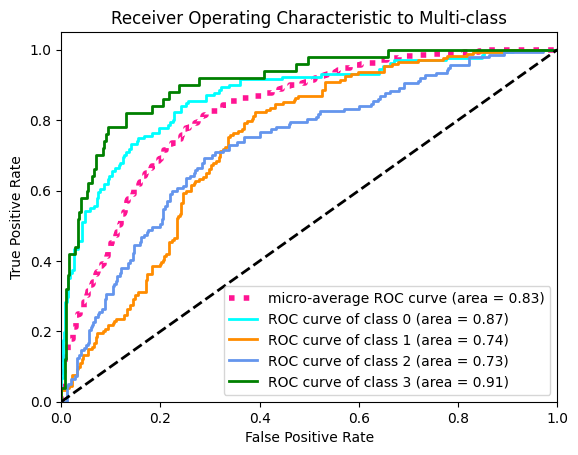

Accuracy: 58.54%


In [8]:
predictions, ground_truths = trainer.predict(test_loader, 4)

In [1]:
#Done